INTRODUCTION:

PyEMMA (Python Emma) is a Python library for the analysis of molecular dynamics (MD) simulations. It is widely used for the analysis of large amounts of simulation data. Its functionalities include the analysis of slow dynamics, clustering, the construction and analysis of Markov models (MSMs) and hidden Markov state models (HMMs).
Key features of PyEMMA:
• Time independent component analysis (TICA): Used to reduce the dimensionality of the simulation data, highlighting the slower dynamics.
• Construction of Markov models (MSMs): Used to model the transitions between different conformational states of a molecule.
• Models of hidden Markov states (HMMs): allows to model systems with hidden states not directly observable.
• Transition Flow Analysis (TPT): Analyzes the flow between different states to identify relevant transition paths.
• Clustering: allows the grouping of similar molecular configurations to reduce the complexity of the data.
• Visualization: Provides tools for viewing analysis results, such as free energy surfaces, transition fluxes, and metastable assignments.

We start our short walkthrough tutorial by loading a topology file (in this case, a PDB) and the trajectory data
Then, download a PDB file of a specific peptide and save it in the data directory:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import mdshare
import pyemma
from pyemma.util.contexts import settings
np.__version__


'1.23.1'

In [2]:

pdb = mdshare.fetch('pentapeptide-impl-solv.pdb', working_directory='data')
files = mdshare.fetch('pentapeptide-*-500ns-impl-solv.xtc', working_directory='data')

print(pdb)
print(files)


data\pentapeptide-impl-solv.pdb
['data\\pentapeptide-00-500ns-impl-solv.xtc', 'data\\pentapeptide-01-500ns-impl-solv.xtc', 'data\\pentapeptide-02-500ns-impl-solv.xtc', 'data\\pentapeptide-03-500ns-impl-solv.xtc', 'data\\pentapeptide-04-500ns-impl-solv.xtc', 'data\\pentapeptide-05-500ns-impl-solv.xtc', 'data\\pentapeptide-06-500ns-impl-solv.xtc', 'data\\pentapeptide-07-500ns-impl-solv.xtc', 'data\\pentapeptide-08-500ns-impl-solv.xtc', 'data\\pentapeptide-09-500ns-impl-solv.xtc', 'data\\pentapeptide-10-500ns-impl-solv.xtc', 'data\\pentapeptide-11-500ns-impl-solv.xtc', 'data\\pentapeptide-12-500ns-impl-solv.xtc', 'data\\pentapeptide-13-500ns-impl-solv.xtc', 'data\\pentapeptide-14-500ns-impl-solv.xtc', 'data\\pentapeptide-15-500ns-impl-solv.xtc', 'data\\pentapeptide-16-500ns-impl-solv.xtc', 'data\\pentapeptide-17-500ns-impl-solv.xtc', 'data\\pentapeptide-18-500ns-impl-solv.xtc', 'data\\pentapeptide-19-500ns-impl-solv.xtc', 'data\\pentapeptide-20-500ns-impl-solv.xtc', 'data\\pentapeptide-21

This code defines three different types of features that will be used to analyze the dynamics of the pentapeptide backbone:

• Torsions of the backbone: Angles φ and ψ between the atoms of the main chain.

• Positions of the atoms of the backbone: Spatial coordinates of the atoms of the main chain.

• Distances between the atoms of the backbone: Distances between pairs of datums of the main chain.

In [21]:

torsions_feat = pyemma.coordinates.featurizer(pdb)
torsions_feat.add_backbone_torsions(cossin=True, periodic=False)
torsions_data = pyemma.coordinates.load(files, features=torsions_feat)
labels = ['backbone\ntorsions']

positions_feat = pyemma.coordinates.featurizer(pdb)
positions_feat.add_selection(positions_feat.select_Backbone())
positions_data = pyemma.coordinates.load(files, features=positions_feat)
labels += ['backbone atom\npositions']

distances_feat = pyemma.coordinates.featurizer(pdb)
distances_feat.add_distances(
    distances_feat.pairs(distances_feat.select_Backbone(), excluded_neighbors=2), periodic=False)
distances_data = pyemma.coordinates.load(files, features=distances_feat)
labels += ['backbone atom\ndistances']


100%|██████████| 25/25 [00:05<00:00,  4.97it/s]                                 


In [4]:

def score_cv(data, dim, lag, number_of_splits=10, validation_fraction=0.5):
    """Compute a cross-validated VAMP2 score.

    We randomly split the list of independent trajectories into
    a training and a validation set, compute the VAMP2 score,
    and repeat this process several times.

    Parameters
    ----------
    data : list of numpy.ndarrays
        The input data.
    dim : int
        Number of processes to score; equivalent to the dimension
        after projecting the data with VAMP2.
    lag : int
        Lag time for the VAMP2 scoring.
    number_of_splits : int, optional, default=10
        How often do we repeat the splitting and score calculation.
    validation_fraction : int, optional, default=0.5
        Fraction of trajectories which should go into the validation
        set during a split.
    """
    # we temporarily suppress very short-lived progress bars
    with pyemma.util.contexts.settings(show_progress_bars=False):
        nval = int(len(data) * validation_fraction)
        scores = np.zeros(number_of_splits)
        for n in range(number_of_splits):
            ival = np.random.choice(len(data), size=nval, replace=False)
            vamp = pyemma.coordinates.vamp(
                [d for i, d in enumerate(data) if i not in ival], lag=lag, dim=dim)
            scores[n] = vamp.score([d for i, d in enumerate(data) if i in ival])
    return scores



C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roa

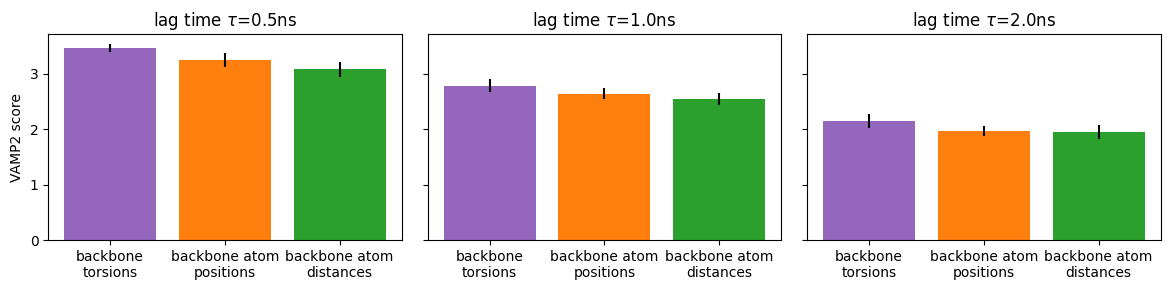

In [5]:

dim = 10

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharey=True)
for ax, lag in zip(axes.flat, [5, 10, 20]):
    torsions_scores = score_cv(torsions_data, lag=lag, dim=dim)
    scores = [torsions_scores.mean()]
    errors = [torsions_scores.std()]
    positions_scores = score_cv(positions_data, lag=lag, dim=dim)
    scores += [positions_scores.mean()]
    errors += [positions_scores.std()]
    distances_scores = score_cv(distances_data, lag=lag, dim=dim)
    scores += [distances_scores.mean()]
    errors += [distances_scores.std()]
    ax.bar(labels, scores, yerr=errors, color=['C4', 'C1', 'C2'])
    ax.set_title(r'lag time $\tau$={:.1f}ns'.format(lag * 0.1))
    if lag == 5:
        # save for later
        vamp_bars_plot = dict(
            labels=labels, scores=scores, errors=errors, dim=dim, lag=lag)
axes[0].set_ylabel('VAMP2 score')
fig.tight_layout()


Graphs show VAMP2 scores for three different types of pentapeptide backbone features.
What is Lag Time?
Lag time is a crucial parameter in molecular dynamics analysis. It represents the time interval in which transitions between different conformational states of the molecule are observed. In the context of VAMP2, it is the time at which the time evolution of the selected features is analyzed. Changing the lag time can significantly affect the VAMP2 scores and thus the conclusions that can be drawn about the system dynamics.

Each bar represents the mean VAMP2 score calculated from multiple replicates (cross-validation).
Error bars indicate the standard deviation of the scores, providing a measure of the variability of the VAMP2 scores obtained.

Analysis of results:

Lag Time = 0.5 ns:
VAMP2 scores are high for all features, with spinal torsion showing the highest score.
This suggests that, at short delay time, the torsions more effectively capture the kinetics of the system compared to the positions and distances of the backbone atoms.

Lag Time = 1.0 ns:
VAMP2 scores decrease compared to τ = 0.5 ns.
Twists and poses have similar scores, while distances have a slightly lower score.

Lag Time = 2.0 ns:
VAMP2 scores decrease further.
All three features show a similar ability to capture the kinetics of the system, but at a lower level compared to shorter delay times.

Conclusions:
Effect of Lag Time: As lag time increases, VAMP2 scores tend to decrease. This could indicate that, for longer delay times, transitions between conformational states are not captured as efficiently.
At short delay times (τ = 0.5 ns), backbone torsions are the most informative features. As the lag time increases, the differences between the features narrow, suggesting that no feature is clearly superior for longer lag times.
These results may help to decide which type of features and which lag time are most appropriate to model the kinetics of the pentapeptide backbone in future simulations and analyses.
We should note that the VAMP-2 score is not suitable for selecting the appropriate lag time, as the scores for different lag times are not comparable.

Therefore, here they only compare different characteristics at each given delay time separately:

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "vamp". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.VAMP instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roa

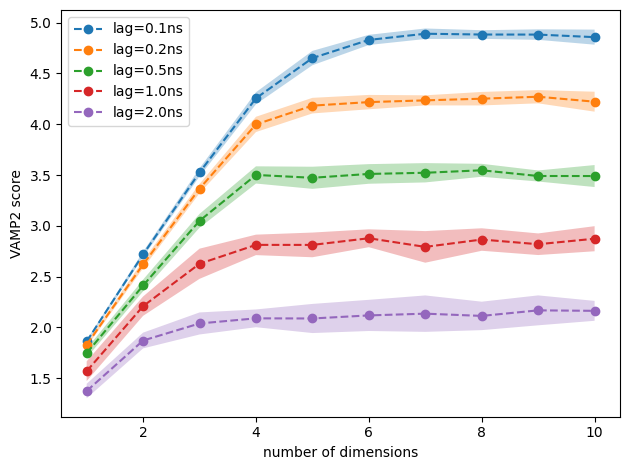

In [6]:

lags = [1, 2, 5, 10, 20]
dims = [i + 1 for i in range(10)]

fig, ax = plt.subplots()
for i, lag in enumerate(lags):
    scores_ = np.array([score_cv(torsions_data, dim, lag)
                        for dim in dims])
    scores = np.mean(scores_, axis=1)
    errors = np.std(scores_, axis=1, ddof=1)
    color = 'C{}'.format(i)
    ax.fill_between(dims, scores - errors, scores + errors, alpha=0.3, facecolor=color)
    ax.plot(dims, scores, '--o', color=color, label='lag={:.1f}ns'.format(lag * 0.1))
ax.legend()
ax.set_xlabel('number of dimensions')
ax.set_ylabel('VAMP2 score')
fig.tight_layout()

This analysis makes it possible to select the number of dimensions and lag time that best capture the dynamics of the system.
A higher VAMP2 score indicates a better representation of the system kinetics.
Variability in scores provides information about the stability of the kinetic representation.
We note that for delay times longer than 0.5 ns, using more than four dimensions does not increase the score, i.e. the first four dimensions contain all the relevant information of the slow dynamics.

Based on this result, they attempt a TICA projection with a delay time of 0.5 ns (5 steps).


The goal of the next step is to find a function that maps the usually high-dimensional input space into some lower-dimensional space that captures the important dynamics. The recommended way of doing so is a time-lagged independent component analysis (TICA), molgedey-94, perez-hernandez-13. They perform TICA (with kinetic map scaling) using the lag time obtained from the VAMP-2 score.

In [7]:
tica = pyemma.coordinates.tica(torsions_data, lag=5)
tica_output = tica.get_output()
tica_concatenated = np.concatenate(tica_output)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)
calculate covariances:   0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 742.39it/s]              


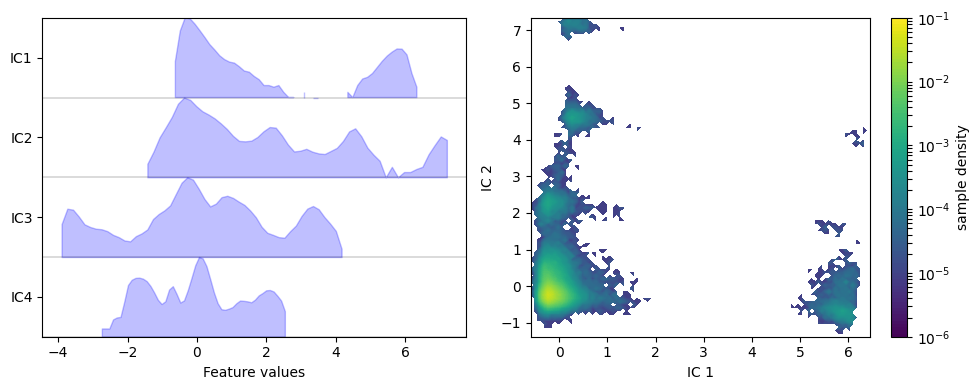

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
pyemma.plots.plot_feature_histograms(
    tica_concatenated,
    ax=axes[0],
    feature_labels=['IC1', 'IC2', 'IC3', 'IC4'],
    ylog=True)
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], logscale=True)
axes[1].set_xlabel('IC 1')
axes[1].set_ylabel('IC 2')
fig.tight_layout()


Interpretation of Views:

1. Histograms of Characteristics:

• The histograms in the first subgraph show the distribution of the first four TICA components (IC1, IC2, IC3, IC4).

• The logarithmic scale on the Y axis makes it possible to better observe the characteristics of the distributions, especially if they have long tails.

2. Joint Density:

• The second subgraph shows the joint density of the first two TICA components (IC1, IC2).

• The logarithmic scale highlights areas of high and low density, helping to identify densely populated and empty regions in the projected space.

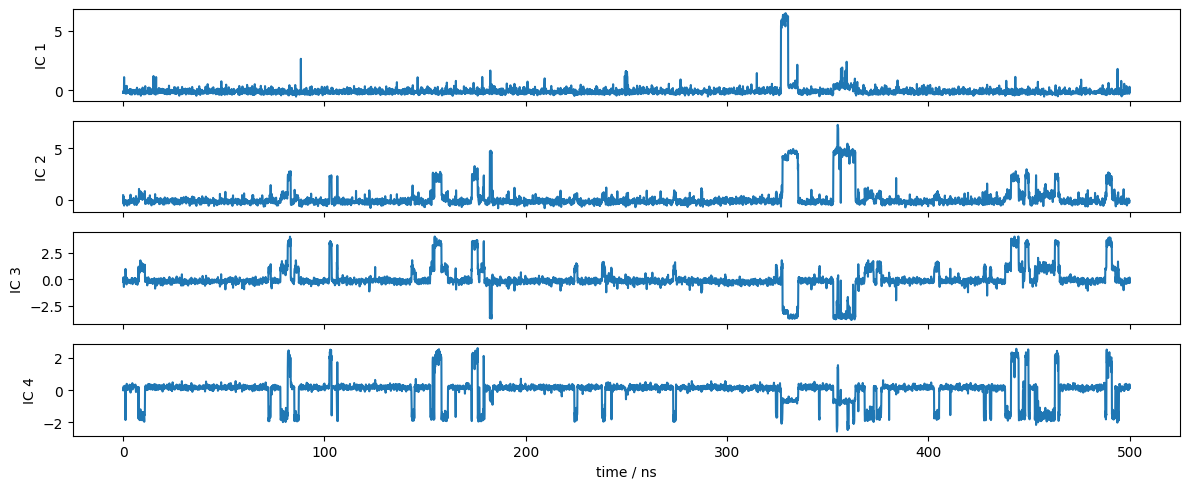

In [9]:

fig, axes = plt.subplots(4, 1, figsize=(12, 5), sharex=True)
x = 0.1 * np.arange(tica_output[0].shape[0])
for i, (ax, tic) in enumerate(zip(axes.flat, tica_output[0].T)):
    ax.plot(x, tic)
    ax.set_ylabel('IC {}'.format(i + 1))
axes[-1].set_xlabel('time / ns')
fig.tight_layout()


This code block aims to:
1. Discretize the TICA coordinates into discrete states using the k-means algorithm.
2. Estimate multiple Markov models (MSM) for different numbers of cluster centers.
3. Assess the quality of these models using the VAMP-2 score with cross-validation.

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw

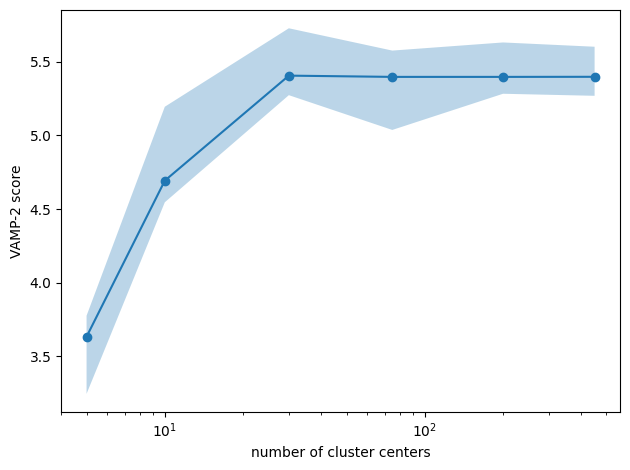

In [22]:
n_clustercenters = [5, 10, 30, 75, 200, 450]

scores = np.zeros((len(n_clustercenters), 5))
for n, k in enumerate(n_clustercenters):
    for m in range(5):
        with pyemma.util.contexts.settings(show_progress_bars=False):
            _cl = pyemma.coordinates.cluster_kmeans(
                tica_output, k=k, max_iter=50, stride=50)
            _msm = pyemma.msm.estimate_markov_model(_cl.dtrajs, 5)
            scores[n, m] = _msm.score_cv(
                _cl.dtrajs, n=1, score_method='VAMP2', score_k=min(10, k))

fig, ax = plt.subplots()
lower, upper = pyemma.util.statistics.confidence_interval(scores.T.tolist(), conf=0.9)
ax.fill_between(n_clustercenters, lower, upper, alpha=0.3)
ax.plot(n_clustercenters, np.mean(scores, axis=1), '-o')
ax.semilogx()
ax.set_xlabel('number of cluster centers')
ax.set_ylabel('VAMP-2 score')
fig.tight_layout()

Number of Cluster Centers (x-axis): Varies logarithmically to better visualize the effect of increasing the number of clusters.

VAMP-2 score (y-axis): Indicates the quality of the MSM model based on cross-validation.

Confidence bands: Show the variability of scores across different iterations.

A higher number of cluster centers generally better captures the system dynamics, but may lead to overfitting the model.

In [10]:

cluster = pyemma.coordinates.cluster_kmeans(
    tica_output, k=75, max_iter=50, stride=10, fixed_seed=1)
dtrajs_concatenated = np.concatenate(cluster.dtrajs)


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from C:\Users\User\AppData\Roaming\Python\Python310\site-packages\decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
initialize kmeans++ centers:  88%|████████▊ | 66/75 [00:00<00:00, 657.56it/s]c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\deeptime\clustering\_kmeans.py:466: UserWarning: Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.
  warnings.warn(f"Algorithm did not reach convergence criterion"
100%|██████████| 50/50 [00:00<00:00, 85.63it/s] 

20-06-24 10:38:43 pyemma.coordinates.clustering.kmeans.KmeansClustering[3547] WARNING  Algorithm did not reach convergence criterion of 1e-05 in 50 iterations. Consider increasing max_iter.



100%|██████████| 25/25 [00:00<00:00, 166.06it/s]                                    


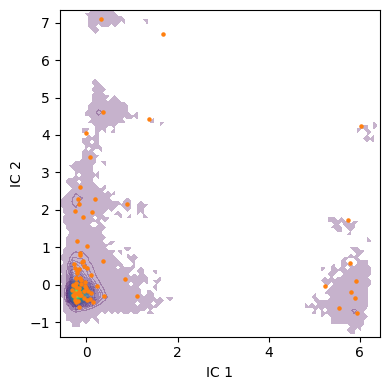

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))
pyemma.plots.plot_density(
    *tica_concatenated[:, :2].T, ax=ax, cbar=False, alpha=0.3)
ax.scatter(*cluster.clustercenters[:, :2].T, s=5, c='C1')
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
fig.tight_layout()


Data density: Density of molecular configurations projected in the first two dimensions of TICA.

Centers of Clusters: Location of the centers of clusters (in yellow) that represent the discrete states.

The plot allows you to inspect how clusters (discrete states) are distributed in TICA space, which is useful for understanding molecular dynamics and cluster quality.

Summary:

Discretization through clustering in the TICA space allows to transform continuous molecular configurations into discrete states, necessary to build Markov models that describe the transitions between these states. Visualization helps to inspect the distribution and density of these states, providing a better understanding of the system dynamics.

Estimation and Validation of MSM (Markov State Model)

Implied Timescales (ITS)
The estimation of implied timescales (ITS) is one of the first validations performed when building a Markov State Model (MSM). These timescales are calculated from the eigenvalues (λ) of the transition matrix of the model.

Provides an approximation of the decorrelation time of the corresponding process and is independent of the model hyperparameter τ. Therefore, ITS convergence is analyzed and τ is chosen within a range where ITS are approximately invariant. It is important to note that lag time also determines the temporal resolution limit of the Markov model.

In this tutorial, ITS is calculated using the pyemma.msm.its() function with a lag time of up to 50 steps, equivalent to 5 nanoseconds (ns) for this dataset (Δt = 0.1 ns). The uncertainty in the implied timescales is quantified using Markov models sampled with a Bayesian scheme.

If this process is too slow, a maximum likelihood MSM can be used by setting the errors argument to None.

The following code shows how to calculate ITS for different lag times using PyEMMA:

100%|██████████| 10/10 [01:02<00:00,  6.22s/it]                        


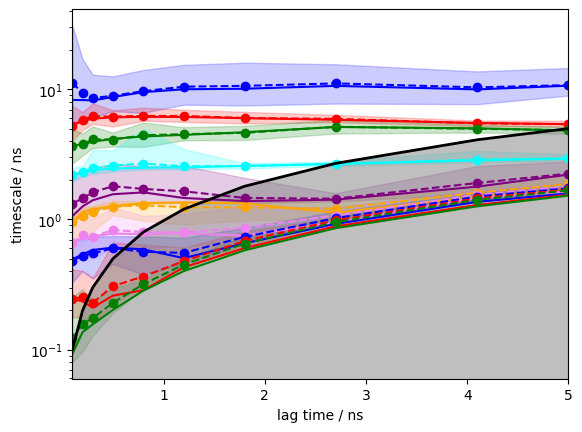

In [12]:
its = pyemma.msm.its(cluster.dtrajs, lags=50, nits=10, errors='bayes')
pyemma.plots.plot_implied_timescales(its, units='ns', dt=0.1);


This code generates a plot where solid lines correspond to ITS from the maximum likelihood MSM, and the shaded areas represent 95% confidence intervals of the samples generated by the Bayesian MSM. Dashed lines show the sample means.

In this example, the implied timescales converge quickly. Above 0.5 ns, the timescales of the slower processes remain constant within the error. This allows selecting a lag time of 5 steps (0.5 ns) to build the Markov model.

After determining the appropriate lag time, the Markov model is built using a Bayesian approach:


In [13]:

msm = pyemma.msm.bayesian_markov_model(cluster.dtrajs, lag=5, dt_traj='0.1 ns')
print('fraction of states used = {:.2f}'.format(msm.active_state_fraction))
print('fraction of counts used = {:.2f}'.format(msm.active_count_fraction))


100%|██████████| 100/100 [00:01<00:00, 50.48it/s]                                                                    


fraction of states used = 1.00
fraction of counts used = 1.00


This code shows that all fractions of states and counts are used, indicating full coverage of the active set.

The Chapman-Kolmogorov test is a technique used to verify the validity of a Markov model.

This test checks whether the transitions predicted by the Markov model ultimately agree with the direct observations of the simulation trajectories.

Purpose of the Chapman-Kolmogorov Test: 
The Chapman-Kolmogorov test evaluates whether the estimated Markov model can correctly reproduce the probabilities of transition between states at different time scales. If the model passes the test, it suggests that the model is a good approximation of the underlying dynamics of the system.

100%|██████████| 5/5 [00:24<00:00,  4.99s/it]                        


TypeError: legend() takes 0-2 positional arguments but 3 were given

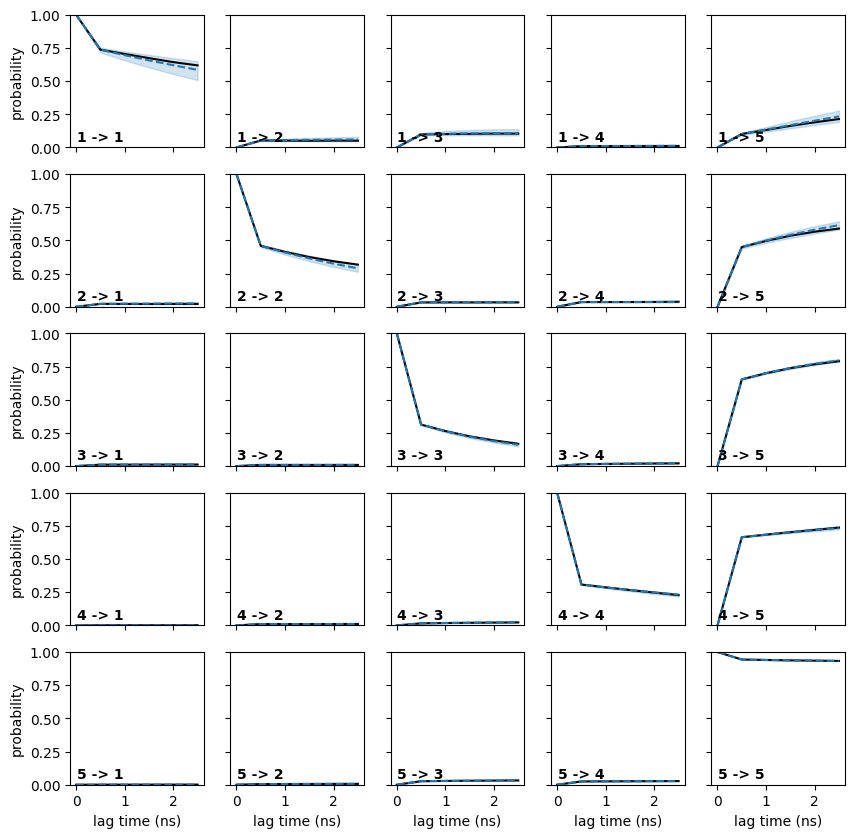

In [14]:
nstates = 5
msm.pcca(nstates)

# Realitzar el test de Chapman-Kolmogorov
cktest = msm.cktest(nstates, mlags=6)

# Visualitzar els resultats del test de Chapman-Kolmogorov
pyemma.plots.plot_cktest(cktest, dt=0.1, units='ns')
plt.show()


In the resulting plot, the solid lines represent the transition probabilities observed directly from the simulation trajectories at different time scales. The dashed lines represent the transition probabilities predicted by the Markov model. If the lines coincide well, this indicates that the Markov model is a good approximation of the system dynamics. If they do not match, it may be necessary to revise the model, possibly by adjusting the parameters or increasing the number of states. (MATCH)

MSM spectral analysis:

Spectral analysis of a Markov Model (MSM) is a technique that involves the study of the eigenvalues ​​and eigenvectors of the transition matrix of the model. This type of analysis provides key information about system dynamics, especially slow dynamics and metastable states.

ValueError: The number of FixedLocator locations (14), usually from a call to set_ticks, does not match the number of labels (16).

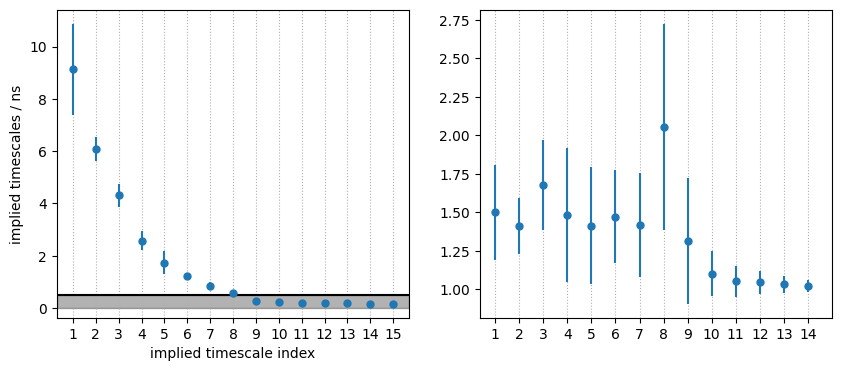

In [16]:
def its_separation_err(ts, ts_err):
    """
    Error propagation from ITS standard deviation to timescale separation.
    """
    return ts[:-1] / ts[1:] * np.sqrt(
        (ts_err[:-1] / ts[:-1])**2 + (ts_err[1:] / ts[1:])**2)


nits = 15

timescales_mean = msm.sample_mean('timescales', k=nits)
timescales_std = msm.sample_std('timescales', k=nits)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].errorbar(
    range(1, nits + 1),
    timescales_mean,
    yerr=timescales_std,
    fmt='.', markersize=10)
axes[1].errorbar(
    range(1, nits),
    timescales_mean[:-1] / timescales_mean[1:],
    yerr=its_separation_err(
        timescales_mean,
        timescales_std),
    fmt='.',
    markersize=10,
    color='C0')

for i, ax in enumerate(axes):
    ax.set_xticks(range(1, nits + 1))
    ax.grid(True, axis='x', linestyle=':')

axes[0].axhline(msm.lag * 0.1, lw=1.5, color='k')
axes[0].axhspan(0, msm.lag * 0.1, alpha=0.3, color='k')
axes[0].set_xlabel('implied timescale index')
axes[0].set_ylabel('implied timescales / ns')
axes[1].set_xticks(range(1, nits))
axes[1].set_xticklabels(
    ["{:d}/{:d}".format(k, k + 1) for k in range(1, nits + 2)],
    rotation=45)
axes[1].set_xlabel('implied timescale indices')
axes[1].set_ylabel('timescale separation')
fig.tight_layout()


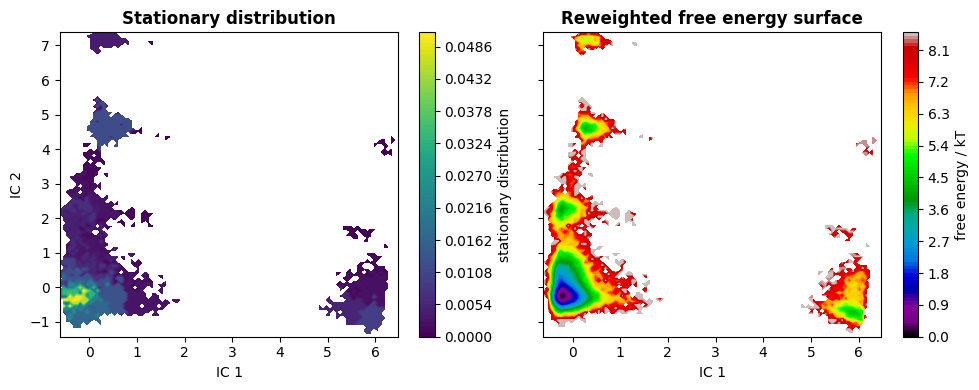

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
pyemma.plots.plot_contour(
    *tica_concatenated[:, :2].T,
    msm.pi[dtrajs_concatenated],
    ax=axes[0],
    mask=True,
    cbar_label='stationary distribution')
pyemma.plots.plot_free_energy(
    *tica_concatenated[:, :2].T,
    weights=np.concatenate(msm.trajectory_weights()),
    ax=axes[1],
    legacy=False)
for ax in axes.flat:
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
axes[0].set_title('Stationary distribution', fontweight='bold')
axes[1].set_title('Reweighted free energy surface', fontweight='bold')
fig.tight_layout()


The first eigenvector is one: True (min=0.9999999999999967, max=1.0000000000000169)


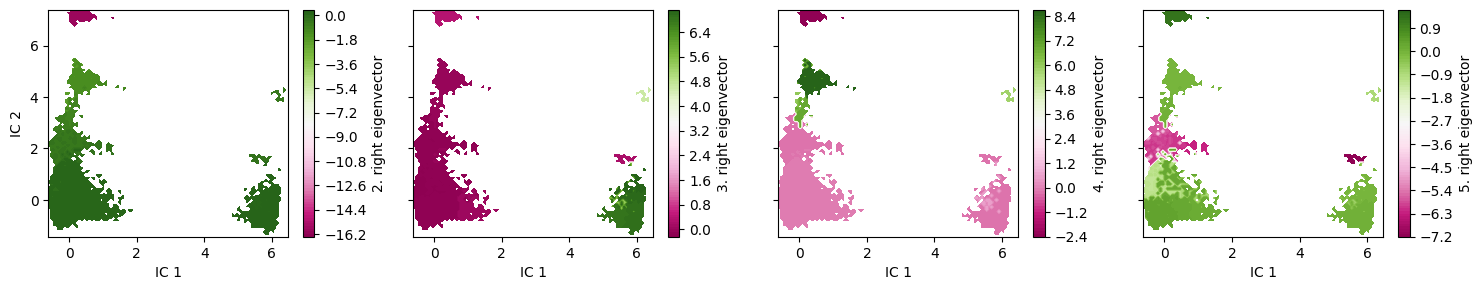

In [17]:
eigvec = msm.eigenvectors_right()
print('The first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(1, 4, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        eigvec[dtrajs_concatenated, i + 1],
        ax=ax,
        cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2),
        mask=True)
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()


In [18]:
msm.pcca(nstates)


PCCA-1378579831760:[{'P': array([[1.03806228e-01, 0.00000000e+00, 0.00000000e+00, ...,
                           0.00000000e+00, 1.64172225e-03, 0.00000000e+00],
                          [0.00000000e+00, 1.95924765e-02, 6.35744514e-04, ...,
                           4.52336424e-04, 4.86326408e-02, 5.83109373e-03],
                          [0.00000000e+00, 5.61369100e-04, 8.03631472e-01, ...,
                           0.00000000e+00, 3.17280792e-03, 5.68351652e-04],
                          ...,
                          [0.00000000e+00, 7.52026872e-03, 0.00000000e+00, ...,
                           1.29870130e-02, 1.30280763e-02, 0.00000000e+00],
                          [9.18162895e-05, 1.17605036e-02, 8.68912342e-04, ...,
                           1.89498843e-04, 4.80531814e-02, 6.35071308e-03],
                          [0.00000000e+00, 1.19462038e-02, 1.31865487e-03, ...,
                           0.00000000e+00, 5.38027313e-02, 4.78468900e-03]]),
                    'm':

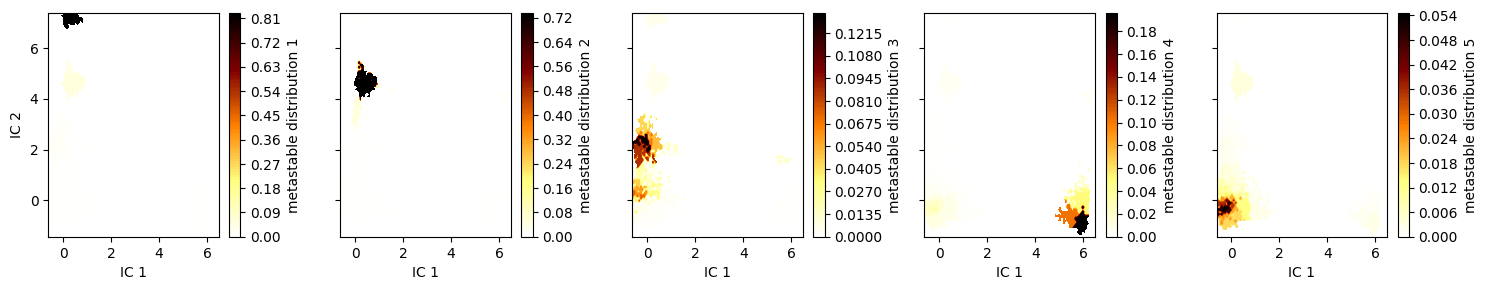

In [19]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *tica_concatenated[:, :2].T,
        msm.metastable_distributions[i][dtrajs_concatenated],
        ax=ax,
        cmap='afmhot_r',
        mask=True,
        cbar_label='metastable distribution {}'.format(i + 1))
    ax.set_xlabel('IC 1')
axes[0].set_ylabel('IC 2')
fig.tight_layout()


ImportError: cannot import name 'get_cmap' from 'matplotlib.cm' (C:\Users\User\AppData\Roaming\Python\Python310\site-packages\matplotlib\cm.py)

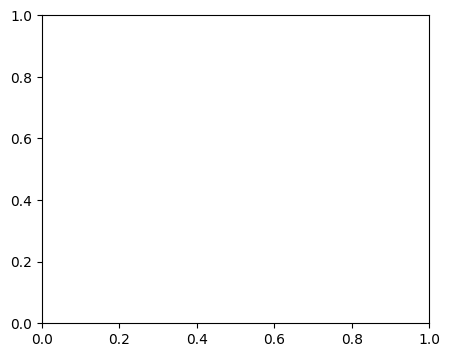

In [20]:
metastable_traj = msm.metastable_assignments[dtrajs_concatenated]

fig, ax = plt.subplots(figsize=(5, 4))
_, _, misc = pyemma.plots.plot_state_map(
    *tica_concatenated[:, :2].T, metastable_traj, ax=ax)
ax.set_xlabel('IC 1')
ax.set_ylabel('IC 2')
misc['cbar'].set_ticklabels([r'$\mathcal{S}_%d$' % (i + 1)
                             for i in range(nstates)])
fig.tight_layout()
